In [1]:
!pip install rich zhipu

In [2]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core import (
    DefaultTopicId,
    FunctionCall,
    Image,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    TypeSubscription,
    message_handler,
)
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.tools import FunctionTool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown

In [3]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

In [4]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(content=system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

In [5]:
class WriterAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )

In [6]:
class IllustratorAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement. "
            "Make sure the images have consistent characters and style.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen, name="generate_image", description="Call this to generate an image. ", strict=True
        )

    # async def _image_gen(
    def _image_gen(
        # self, character_appearence: str, style_attributes: str, worn_and_carried: str, scenario: str
        self, appear: str, style_attributes: str, worn_and_carried: str, scenario: str
    ) -> str:
        prompt = f"Digital painting of a {appear} character with {style_attributes}. Wearing {worn_and_carried}, {scenario}."
        # response = await self._image_client.images.generate(
        #     prompt=prompt, model="dall-e-3", response_format="b64_json", size="1024x1024"
        # )
        # return response.data[0].b64_json  # type: ignore

        from zhipu import draw_image_with_b64
        return draw_image_with_b64(prompt)

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            Console().print(arguments)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            image = Image.from_pil(image.image.resize((256, 256)))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

In [7]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

In [8]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            content=selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

In [9]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

from models import qwen_25_1_5b, qwen_25_7b, llava_7b, llama3_sd_prompt
model_client = qwen_25_7b()

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        # model_client=OpenAIChatCompletionClient(
        #     model="gpt-4o-2024-08-06",
        #     # api_key="YOUR_API_KEY",
        # ),
        model_client=llava_7b(),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        # model_client=OpenAIChatCompletionClient(
        #     model="gpt-4o-2024-08-06",
        #     # api_key="YOUR_API_KEY",
        # ),
        model_client=model_client,
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))


illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        # model_client=OpenAIChatCompletionClient(
        #     model="gpt-4o-2024-08-06",
        #     # api_key="YOUR_API_KEY",
        # ),
        model_client=model_client,
        image_client=openai.AsyncClient(
            api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        # model_client=OpenAIChatCompletionClient(
        #     model="gpt-4o-2024-08-06",
        #     # api_key="YOUR_API_KEY",
        # ),
        model_client=model_client,
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

Writer:

当然，我很乐意为您创作一篇关于姜饼人的短篇故事。下面的故事简明有趣，并附有几处描述性细节，希望能激发您的想象。尽管 
我无法直接提供插图，但我会用文字让故事情节尽可能生动。                                                             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
《迷路的姜饼人》                                                                                                   

在一个遥远的森林里，住着一群快乐的姜饼人——他们生活在一个甜蜜的小村庄里。每当夜幕降临，月亮洒下银色的光辉时，这些小 
小的糖果角色们会在小屋前举行秘密聚会。然而，在一个风和日丽的日子里，一个新的故事开始了。                           

一天下午，村子里最古老的姜饼师傅准备将制作姜饼人的模具放回架子上时，不小心将一只精巧的小袋子遗落了。这只小袋子里装 
着一只尚未被烘烤的独特姜饼人——一颗新诞生的心跳动的结晶。恰巧，一阵微风吹过，把那块未加工的小姜饼吹到了森林中。     

这片森林对于这个从未离开过的小小姜饼人来说是一个充满惊喜的新世界。他被五颜六色的花朵包围着、被绿草覆盖的地面以及远 
处鸟鸣和水流声吸引着。这个新奇的世界让这个小姜饼人心跳加速，他四处张望，但每当回头时，发现总是空旷无人。           

在探索的过程中，这只未命名的小姜饼人与森林里的动物们偶然相遇。他遇到了一只正在寻找食物的小松鼠，并与它一起吃到了美 
味的坚果；他还帮助了一只迷路的小鸟找到了回家的道路，在旅途中，小姜饼人还学会了分享和友谊的价值。                   

正当夜幕低垂时分，月光开始在枝叶间形成斑驳光影。这时，一道奇异的光芒从森林深处直通向天空——那正是遗落的那个装着未烘 
焙姜饼人的袋子发出的光。看到这一景象，小姜饼人感到一阵温暖和感动。                                                 

“或许，这份爱意才是我真正的家。”思考片刻后，他决定返回村庄。虽然离家有点儿迷路，但凭借森林里的新朋友给方向感上的帮 
助以及勇气和智慧指引，最终他安全回到了熟悉的家园，那座充满笑声与温馨的小屋前。                                     

从那天起，每当月亮升起、风轻轻吹过时，大家都能看到一个新面孔在姜饼人的村庄里出现，在篝火旁讲述着属于它的奇妙冒险故 
事。而那个曾经失散的小盒子，则永远地挂在老姜饼师傅的橱柜上，成为了他最珍贵的记忆之一。                             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
这段故事中，您可以想象一座温馨的村舍灯火通明，旁边摆放着刚出炉的各式各样的姜饼小人儿；森林中的场景可以用温柔月光下 
轻盈跳动的松鼠和鸟儿来描绘；而最后回到家中的情节，则可以是温暖的灯光与家人的笑脸欢迎他回家。

Illustrator:

{
    'appear': 'choco_brown_skin, round_brown_hat_with_ear_flaps, red_scarf, cozy_grandmas_clothes',
    'scenario': 'a choco_brown_skin qipao qing person holding a basket full of nuts and carrying a small flashlight
walking through the forest at night under the moonlight',
    'style_attributes': 'whimsical, soft_watercolor, fairy_tale_setting',
    'worn_and_carried': 'basket_full_of_nuts, tiny_flashlight'
}

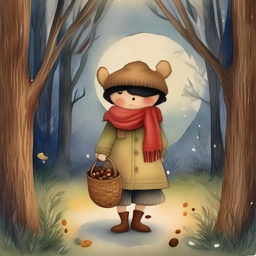

{
    'appear': 'light_brown_hair, green_jumpsuit_with_leaf_prints, wings_on_shoulders, warm_smile',
    'scenario': 'a light_brown_haired qipao qing person with green leaf print jumpsuit, flying through the forest 
with acorns in hands while helping a confused bird find its way home under the golden moonlight',
    'style_attributes': 'whimsical, soft_watercolor, fairy_tale_setting',
    'worn_and_carried': 'acorns_in_hands'
}

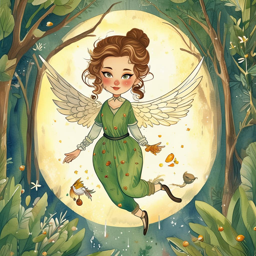

{
    'appear': 'choco_brown_skin, round_nose, big_blond_hair, warm_smile, cozy_grandmas_clothes_2',
    'scenario': 'a choco_brown_skin qipao qing person with warm smile wearing cozy grandmas clothes 2, standing by 
a homely house in front of which hangs a homemade moonbox adorned with heart decorations under the golden 
moonlight',
    'style_attributes': 'whimsical, soft_watercolor, fairy_tale_setting',
    'worn_and_carried': 'homemade_moonbox_with_hearts_on_it'
}

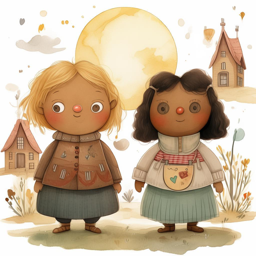

Editor:

As an editor, my main focus would be on ensuring that the story is engaging and effective in its goal of           
illustrating the charm and warmth of the forest's inhabitants. The style of illustration should appeal to a wide   
audience, especially those who enjoy fantasy and fairy-tale imagery featuring anthropomorphic characters.          

I see that the image you have shared is a beautiful illustration depicting two charming cartoon characters in an   
enchanting forest night setting. Here's my feedback on the elements:                                               

 1 Character Design: The characters are adorable and detailed, capturing the whimsy of fantasy creatures. Their    
   clothing, expressions, and settings give them great character and narrative appeal.                             
 2 Mood: The color palette is warm and evokes a sense of wonder and serenity, which aligns well with the story     
   you've provided. However, the nighttime scene might need a bit more contrast and perhaps some additional ambient
   lighting to highlight more details and create a more dynamic image.                                             
 3 Setting: The forest background seems naturalistic and inviting, setting a lovely backdrop for the characters and
   inviting the viewer into this lush fantasy world. Additional elements like mist or light effects may enhance the
   magical atmosphere.                                                                                             
 4 Storytelling Elements: Consider adding subtle cues that tell a little bit more about the story, such as the     
   presence of other forest creatures, like birds or fireflies, and perhaps some hints at the world outside the    
   forest. The inclusion of these could help create context for the viewer without overwhelming them with          
   exposition.                                                                                                     
 5 Composition: The composition is strong, placing the characters in a way that invites the viewer to explore both 
   the details within their presence and around them as they stand by the trees. It's important to ensure balance  
   within the image while maintaining clear focus on the subjects.                                                 

Overall, this illustration has great potential to capture the essence of your story. With a bit more detail in     
lighting and perhaps some environmental storytelling elements, it could be even more immersive. Keep up the good   
work!

Illustrator:

{
    'appear': 'charming and whimsical',
    'scenario': 'A cozy firelit cottage in a sunny afternoon, surrounded by freshly baked gingerbread characters 
ready for the night gathering.',
    'style_attributes': 'cute cartoon style with detailed backgrounds',
    'worn_and_carried': ''
}

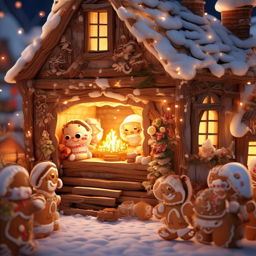

{
    'appear': 'mysterious and magical',
    'scenario': 'Two gingerbread characters walking through a tranquil forest at dusk, accompanied by a few lighted
fairy lights or fireflies.',
    'style_attributes': 'fantasy woodland setting with soft moonlight, soft pastel colors, detailed forest 
elements',
    'worn_and_carried': ''
}

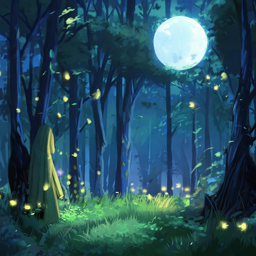

{
    'appear': 'warm and inviting',
    'scenario': 'A gingerbread character returning home to a cozy village cottage under moonlight, surrounded by 
other baked characters enjoying their gathering.',
    'style_attributes': 'cute cartoon style with detailed backgrounds, clear focus on the central characters',
    'worn_and_carried': ''
}

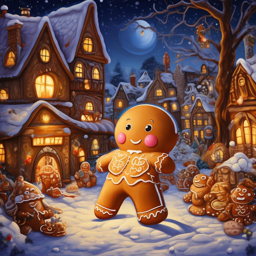

Editor:

As an editor, my priority would be to maintain a cohesive and delightful atmosphere in the illustrations. From what
I see, this image captures the magic and whimsy of your fairy-tale characters well.                                

 1 Character Design: The two characters are visually appealing and add personality to the story through their      
   expressions. Their costumes suggest a connection between them, which could be used more to engage the viewer    
   with storyline context, such as their occupations or roles in the story.                                        
 2 Mood: The nighttime setting is enchanting and perfectly complements the fantasy theme of your characters and    
   forest environment. The use of candlelight gives a warm and inviting feel to the scene, without being           
   overwhelmingly bright. Additional details like the soft glow from distant sources could further elevate the     
   magical atmosphere.                                                                                             
 3 Setting: The lush, snowy forest around them feels wonderfully serene yet slightly mysterious. More subtle cues  
   in the background, such as a hint of starlight or a silhouette of a mythical creature like a fox or a bird,     
   could enhance the storytelling aspect without being distracting.                                                
 4 Storytelling Elements: The details in the gingerbread houses and the presence of other characters, if any, would
   provide context for how the forest is populated and its significance to your character's journey. More careful  
   consideration of the placement of these characters could hint at their relationships within the story and their 
   roles in the community.                                                                                         
 5 Composition: The composition is strong, with good balance between the characters standing in the foreground and 
   the cozy houses providing context for their setting. Considering additional forest elements like waterfalls or  
   other wildlife could introduce more diversity to the environment and its inhabitants.                           

Overall, this image is a delightful piece of art that captures the essence of your story beautifully. To make it   
more engaging, ensuring subtle storytelling elements are balanced with artistic appeal would be key.

User:                                                       

APPROVE

In [10]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            # content="Please write a short story about the gingerbread man with up to 3 photo-realistic illustrations.",
            content="请写一个关于姜饼人的短故事，并附上最多3张逼真的插画。",
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()